#### Experiment: 

Evaluate pruning by magnitude weighted by coactivations (more thorough evaluation), compare it to baseline (SET), in GSC. Applied only to linear layers

#### Motivation.

Check if results are consistently above baseline.

#### Conclusion


In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import glob
import tabulate
import pprint
import click
import numpy as np
import pandas as pd
from ray.tune.commands import *
from nupic.research.frameworks.dynamic_sparse.common.browser import *

import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.ndimage.filters import gaussian_filter1d

%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style="whitegrid")
sns.set_palette("colorblind")

## Load and check data

In [43]:
exps = ['comparison_set']
paths = [os.path.expanduser("~/nta/results/{}".format(e)) for e in exps]
df = load_many(paths)

IndexError: list index out of range

In [16]:
exps = ['comparison_pruning_2' , 'comparison_iterative_pruning_2'] # , 'comparison_set']
paths = [os.path.expanduser("~/nta/results/{}".format(e)) for e in exps]
df = load_many(paths)

In [17]:
df.head(5)

,Experiment Name,train_acc_max,train_acc_max_epoch,train_acc_min,train_acc_min_epoch,train_acc_median,train_acc_last,val_acc_max,val_acc_max_epoch,val_acc_min,...,start_pruning_epoch,target_final_density,weight_decay,experiment_type,first_run,hebbian_grow,hebbian_prune_perc,iterative_pruning_schedule,pruning_early_stop,weight_prune_perc
0,0_target_final_density=0.1,0.95418,199,0.28814,0,0.89213,0.95418,0.8692,170,0.4052,...,1.0,0.10,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1_target_final_density=0.15,0.96978,193,0.25938,0,0.89539,0.96880,0.8789,160,0.3710,...,1.0,0.15,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2_target_final_density=0.2,0.97864,195,0.30640,0,0.89862,0.97856,0.8770,167,0.4360,...,1.0,0.20,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3_target_final_density=0.25,0.98144,195,0.29424,0,0.89384,0.98078,0.8779,190,0.4156,...,1.0,0.25,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4_target_final_density=0.3,0.98132,196,0.26182,0,0.88829,0.98000,0.8728,184,0.3888,...,1.0,0.30,0.0005,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.shape

(38, 50)

In [19]:
df.columns

Index(['Experiment Name', 'train_acc_max', 'train_acc_max_epoch',
       'train_acc_min', 'train_acc_min_epoch', 'train_acc_median',
       'train_acc_last', 'val_acc_max', 'val_acc_max_epoch', 'val_acc_min',
       'val_acc_min_epoch', 'val_acc_median', 'val_acc_last', 'val_acc_all',
       'epochs', 'experiment_file_name', 'trial_time', 'mean_epoch_time',
       'augment_images', 'checkpoint_dir', 'data_dir', 'dataset_name',
       'device', 'end_pruning_epoch', 'input_size', 'learning_rate',
       'local_dir', 'lr_gamma', 'lr_milestones', 'lr_scheduler', 'model',
       'momentum', 'name', 'nesterov_momentum', 'network', 'num_classes',
       'on_perc', 'optim_alg', 'sparse_end', 'sparse_start',
       'start_pruning_epoch', 'target_final_density', 'weight_decay',
       'experiment_type', 'first_run', 'hebbian_grow', 'hebbian_prune_perc',
       'iterative_pruning_schedule', 'pruning_early_stop',
       'weight_prune_perc'],
      dtype='object')

In [20]:
df['target_final_density']

0     0.10
1     0.15
2     0.20
3     0.25
4     0.30
5     0.35
6     0.40
7     0.45
8     0.50
9     0.55
10    0.60
11    0.65
12    0.70
13    0.75
14    0.80
15    0.85
16    0.90
17    0.95
18    1.00
19    1.00
20    0.95
21    0.90
22    0.85
23    0.80
24    0.75
25    0.70
26    0.65
27    0.60
28    0.55
29    0.50
30    0.45
31    0.40
32    0.35
33    0.30
34    0.25
35    0.20
36    0.15
37    0.10
Name: target_final_density, dtype: float64

In [21]:
df.columns

Index(['Experiment Name', 'train_acc_max', 'train_acc_max_epoch',
       'train_acc_min', 'train_acc_min_epoch', 'train_acc_median',
       'train_acc_last', 'val_acc_max', 'val_acc_max_epoch', 'val_acc_min',
       'val_acc_min_epoch', 'val_acc_median', 'val_acc_last', 'val_acc_all',
       'epochs', 'experiment_file_name', 'trial_time', 'mean_epoch_time',
       'augment_images', 'checkpoint_dir', 'data_dir', 'dataset_name',
       'device', 'end_pruning_epoch', 'input_size', 'learning_rate',
       'local_dir', 'lr_gamma', 'lr_milestones', 'lr_scheduler', 'model',
       'momentum', 'name', 'nesterov_momentum', 'network', 'num_classes',
       'on_perc', 'optim_alg', 'sparse_end', 'sparse_start',
       'start_pruning_epoch', 'target_final_density', 'weight_decay',
       'experiment_type', 'first_run', 'hebbian_grow', 'hebbian_prune_perc',
       'iterative_pruning_schedule', 'pruning_early_stop',
       'weight_prune_perc'],
      dtype='object')

In [163]:
# df.groupby(['model', 'network', 'on_perc'])['model', 'network', 'on_perc'].count()

 ## Analysis

Experiment Details

In [29]:
# Did any  trials failed?
num_epochs = 200
df[df["epochs"]<num_epochs]["epochs"].count()

0

In [30]:
# Removing failed or incomplete trials
df_origin = df.copy()
df = df_origin[df_origin["epochs"]>=30]
df.shape

(38, 50)

In [34]:
# helper functions
def mean_and_std(s):
    return "{:.3f} ± {:.3f}".format(s.mean(), s.std())

def round_mean(s):
    return "{:.0f}".format(round(s.mean()))

stats = ['min', 'max', 'mean', 'std']

def agg(columns, filter=None, round=3):
    if filter is None:
        return (df.groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)
    else:
        return (df[filter].groupby(columns)
             .agg({'val_acc_max_epoch': round_mean,
                   'val_acc_max': stats,                
                   'model': ['count']})).round(round)


In [39]:
df['experiment_type']

0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
5                  NaN
6                  NaN
7                  NaN
8                  NaN
9                  NaN
10                 NaN
11                 NaN
12                 NaN
13                 NaN
14                 NaN
15                 NaN
16                 NaN
17                 NaN
18                 NaN
19    IterativePruning
20    IterativePruning
21    IterativePruning
22    IterativePruning
23    IterativePruning
24    IterativePruning
25    IterativePruning
26    IterativePruning
27    IterativePruning
28    IterativePruning
29    IterativePruning
30    IterativePruning
31    IterativePruning
32    IterativePruning
33    IterativePruning
34    IterativePruning
35    IterativePruning
36    IterativePruning
37    IterativePruning
Name: experiment_type, dtype: object

In [40]:
agg(['model', 'target_final_density'])

val_acc_max_epoch val_acc_max  \
                                                  round_mean         min   
model                 target_final_density                                 
IterativePruningModel 0.10                               172       0.836   
                      0.15                               187       0.831   
                      0.20                               167       0.834   
                      0.25                               162       0.828   
                      0.30                               194       0.834   
                      0.35                               185       0.832   
                      0.40                               195       0.832   
                      0.45                               176       0.831   
                      0.50                               191       0.830   
                      0.55                               183       0.825   
                      0.60                               173       0.830   
                      0.65                               166       0.834   
                      0.70                               191       0.833   
                      0.75                               175       0.836   
                      0.80                               194       0.831   
                      0.85                               161       0.834   
                      0.90                               196       0.832   
                      0.95                               167       0.836   
                      1.00                               171       0.834   
PruningModel          0.10                               170       0.869   
                      0.15                               160       0.879   
                      0.20                               167       0.877   
                      0.25                               190       0.878   
                      0.30                               184       0.873   
                      0.35                               196       0.881   
                      0.40                               165       0.883   
                      0.45                               185       0.877   
                      0.50                               166       0.883   
                      0.55                               168       0.884   
                      0.60                               192       0.882   
                      0.65                               195       0.880   
                      0.70                               172       0.884   
                      0.75                               174       0.883   
                      0.80                               172       0.885   
                      0.85                               180       0.886   
                      0.90                               199       0.884   
                      0.95                               188       0.883   
                      1.00                               176       0.885   

                                                             model  
                                              max   mean std count  
model                 target_final_density                          
IterativePruningModel 0.10                  0.836  0.836 NaN     1  
                      0.15                  0.831  0.831 NaN     1  
                      0.20                  0.834  0.834 NaN     1  
                      0.25                  0.828  0.828 NaN     1  
                      0.30                  0.834  0.834 NaN     1  
                      0.35                  0.832  0.832 NaN     1  
                      0.40                  0.832  0.832 NaN     1  
                      0.45                  0.831  0.831 NaN     1  
                      0.50                  0.830  0.830 NaN     1  
                      0.55                  0.825  0.825 NaN     1  
                      0.60   

##### Plot accuracy over epochs

In [116]:
# translate model names
rcParams['figure.figsize'] = 16, 8
d = {
    'GSCHeb': 'Large Dense',
    'GSCHebSmall': 'Small Dense',
    'DSNNWeightedMag': 'Dynamic Sparse DSNN',
    'DSNNMixedHeb': 'Dynamic Sparse SET ',
    'SparseModel': 'Static Sparse',        
}

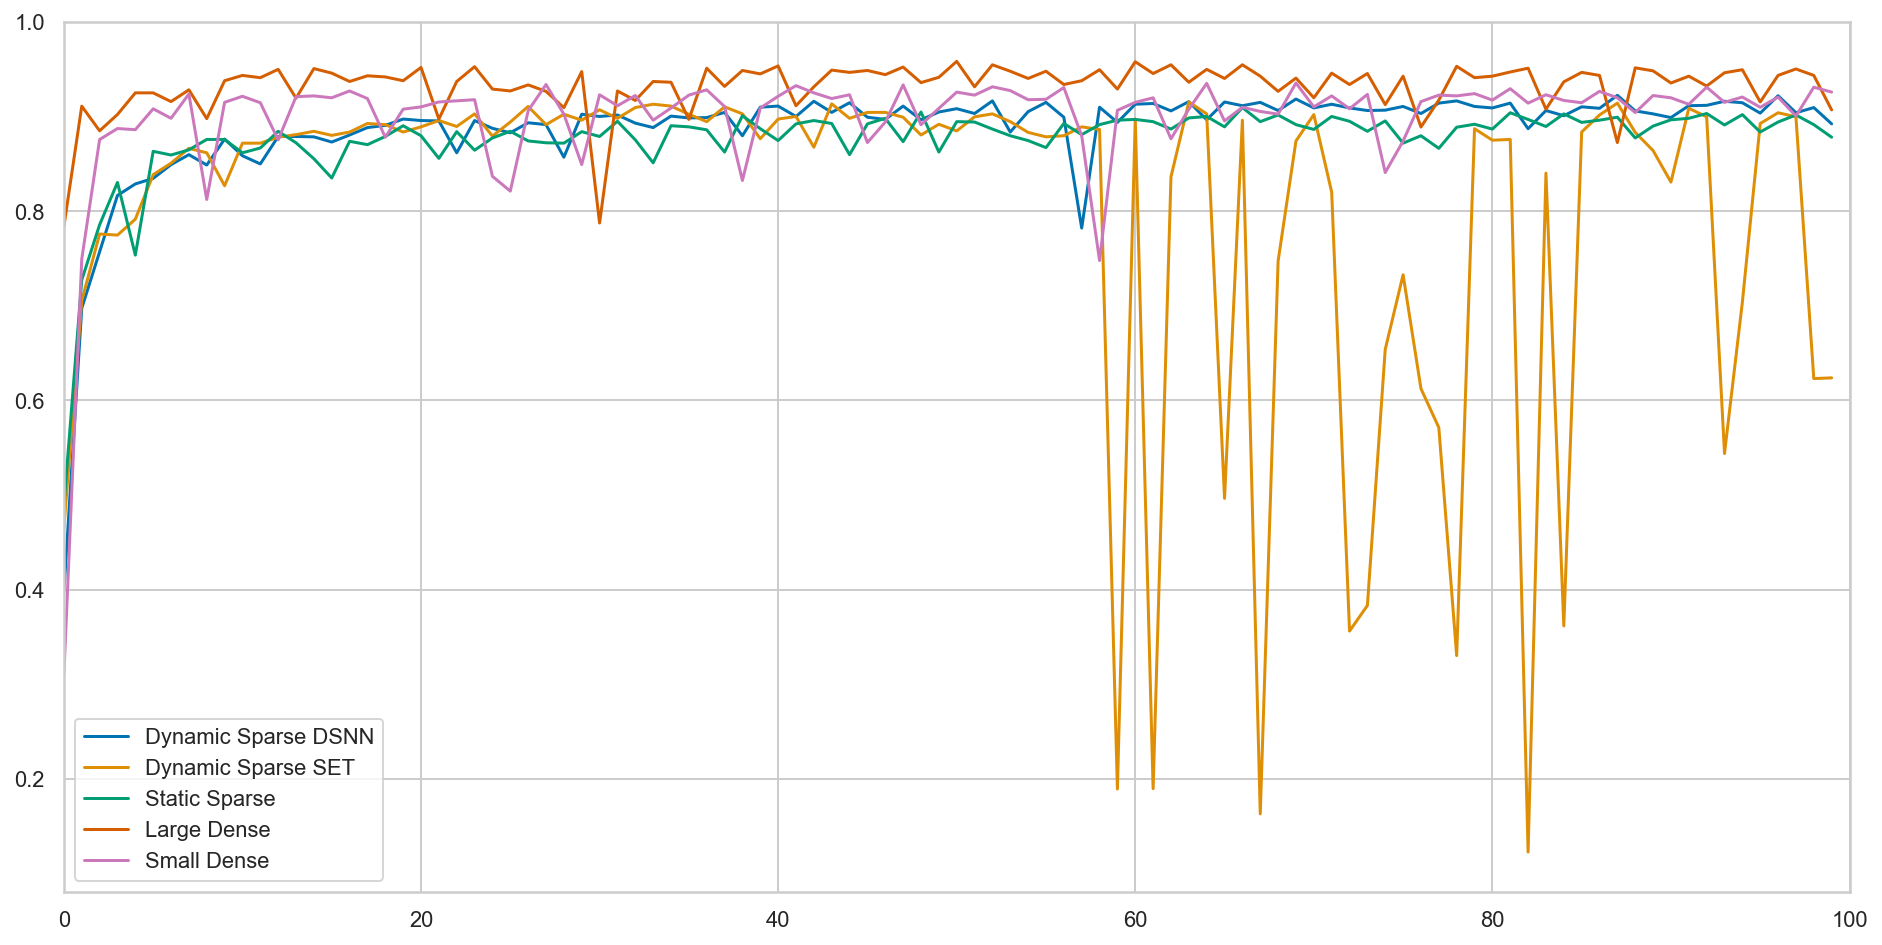

In [213]:
exp_dense = '/Users/lsouza/nta/results/improved_mag_gsc_dense_test2/experiment_state-2019-09-20_19-49-30.json'

def plot_acc(attr, label, input_filter):
    filter = (df[attr] == label) & input_filter
    data = np.array(list(df[filter]['val_acc_all']))
    avg_data=data[3]
    # avg_data = data.mean(axis=0)
    smoothed_data = gaussian_filter1d(avg_data, sigma=1)
    plt.plot(avg_data, label=d[label])

for model in ['DSNNWeightedMag', 'DSNNMixedHeb', 'SparseModel']:
    plot_acc('model', model, (df['on_perc'] == 0.04))
    
for network in ['GSCHeb', 'GSCHebSmall']:
    plot_acc('network', network, (df['model'] == 'BaseModel'))

    
plt.legend()
# plt.ylim((0.6,1));
plt.xlim((0,100));

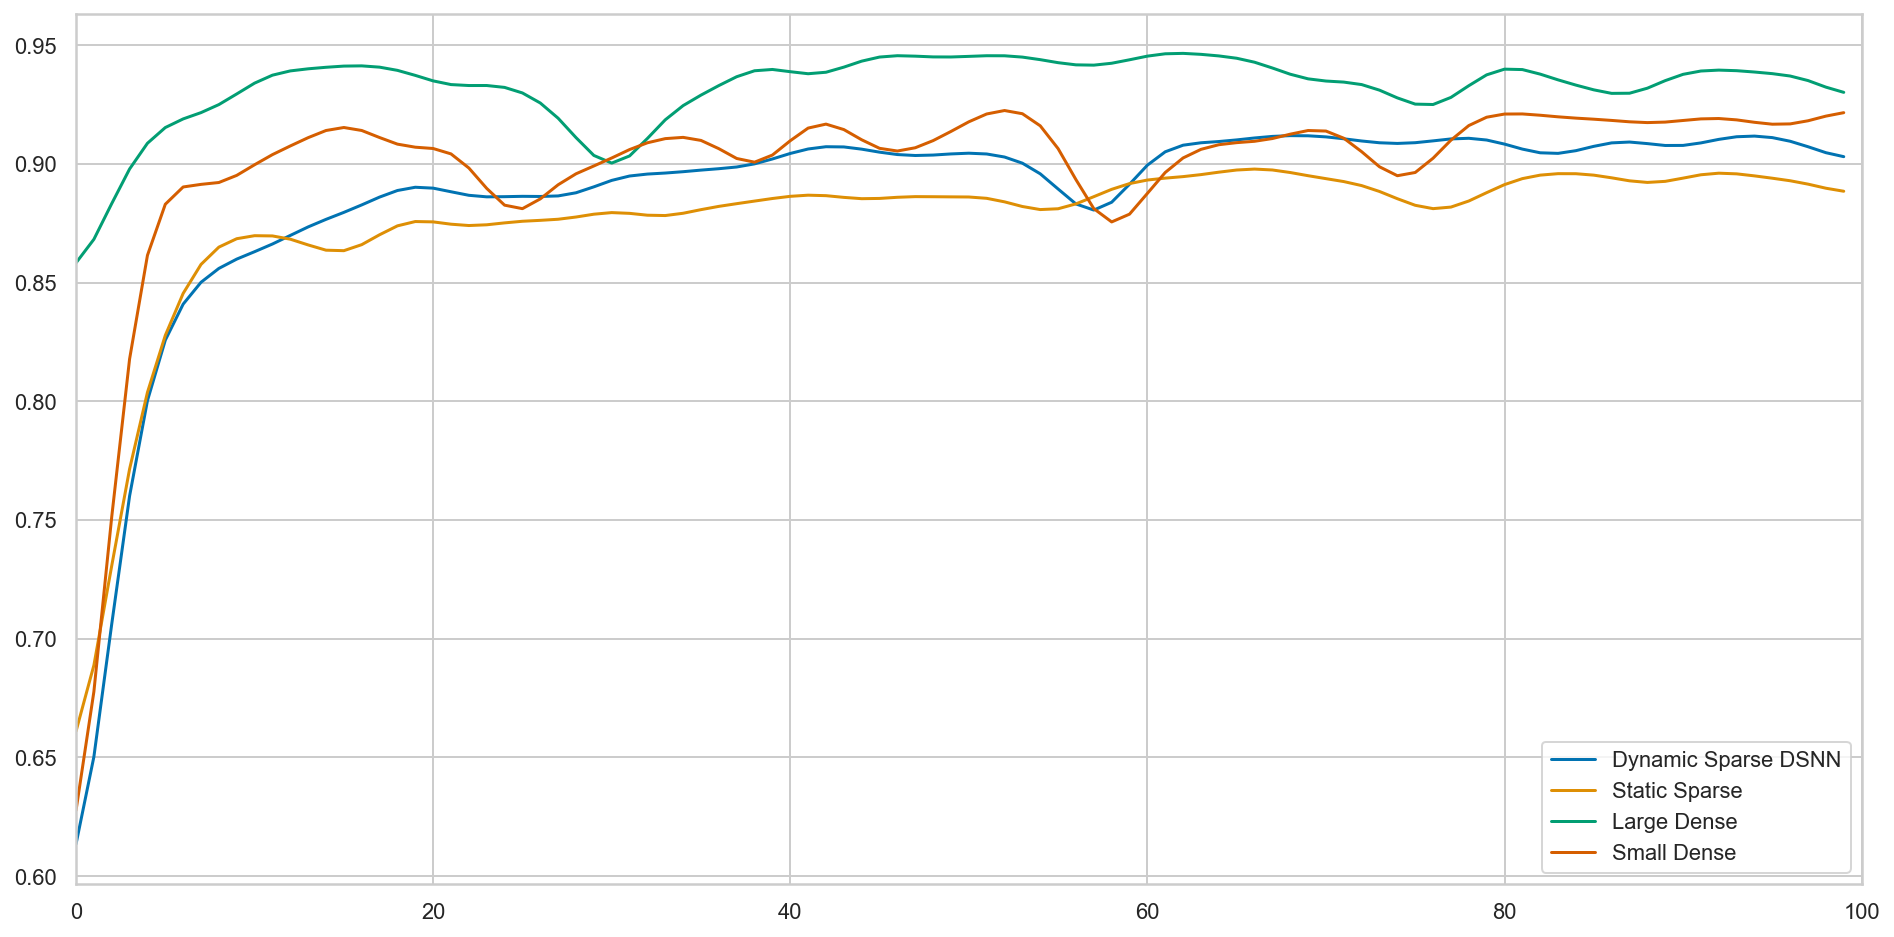

In [215]:
exp_dense = '/Users/lsouza/nta/results/improved_mag_gsc_dense_test2/experiment_state-2019-09-20_19-49-30.json'

def plot_acc(attr, label, input_filter):
    filter = (df[attr] == label) & input_filter
    data = np.array(list(df[filter]['val_acc_all']))
    avg_data=data[3]
    # avg_data = data.mean(axis=0)
    smoothed_data = gaussian_filter1d(avg_data, sigma=2)
    plt.plot(smoothed_data, label=d[label])

for model in ['DSNNWeightedMag', 'SparseModel']:
    plot_acc('model', model, (df['on_perc'] == 0.04))
    
for network in ['GSCHeb', 'GSCHebSmall']:
    plot_acc('network', network, (df['model'] == 'BaseModel'))

    
plt.legend()
# plt.ylim((0.6,1));
plt.xlim((0,100));

In [189]:
print(df[filter]['val_acc_all'].shape)

(10,)


In [190]:
filter = (df['network'] == 'GSCHeb') & (df['model'] == 'BaseModel')
for idx in range(10):
    print(len(df[filter]['val_acc_all'].iloc[idx]))
np.array(list(df[filter]['val_acc_all'])).shape

100
100
100
100
100
100
100
100
100
100


(10, 100)

(10, 100)
(100,)
(10, 100)
(100,)


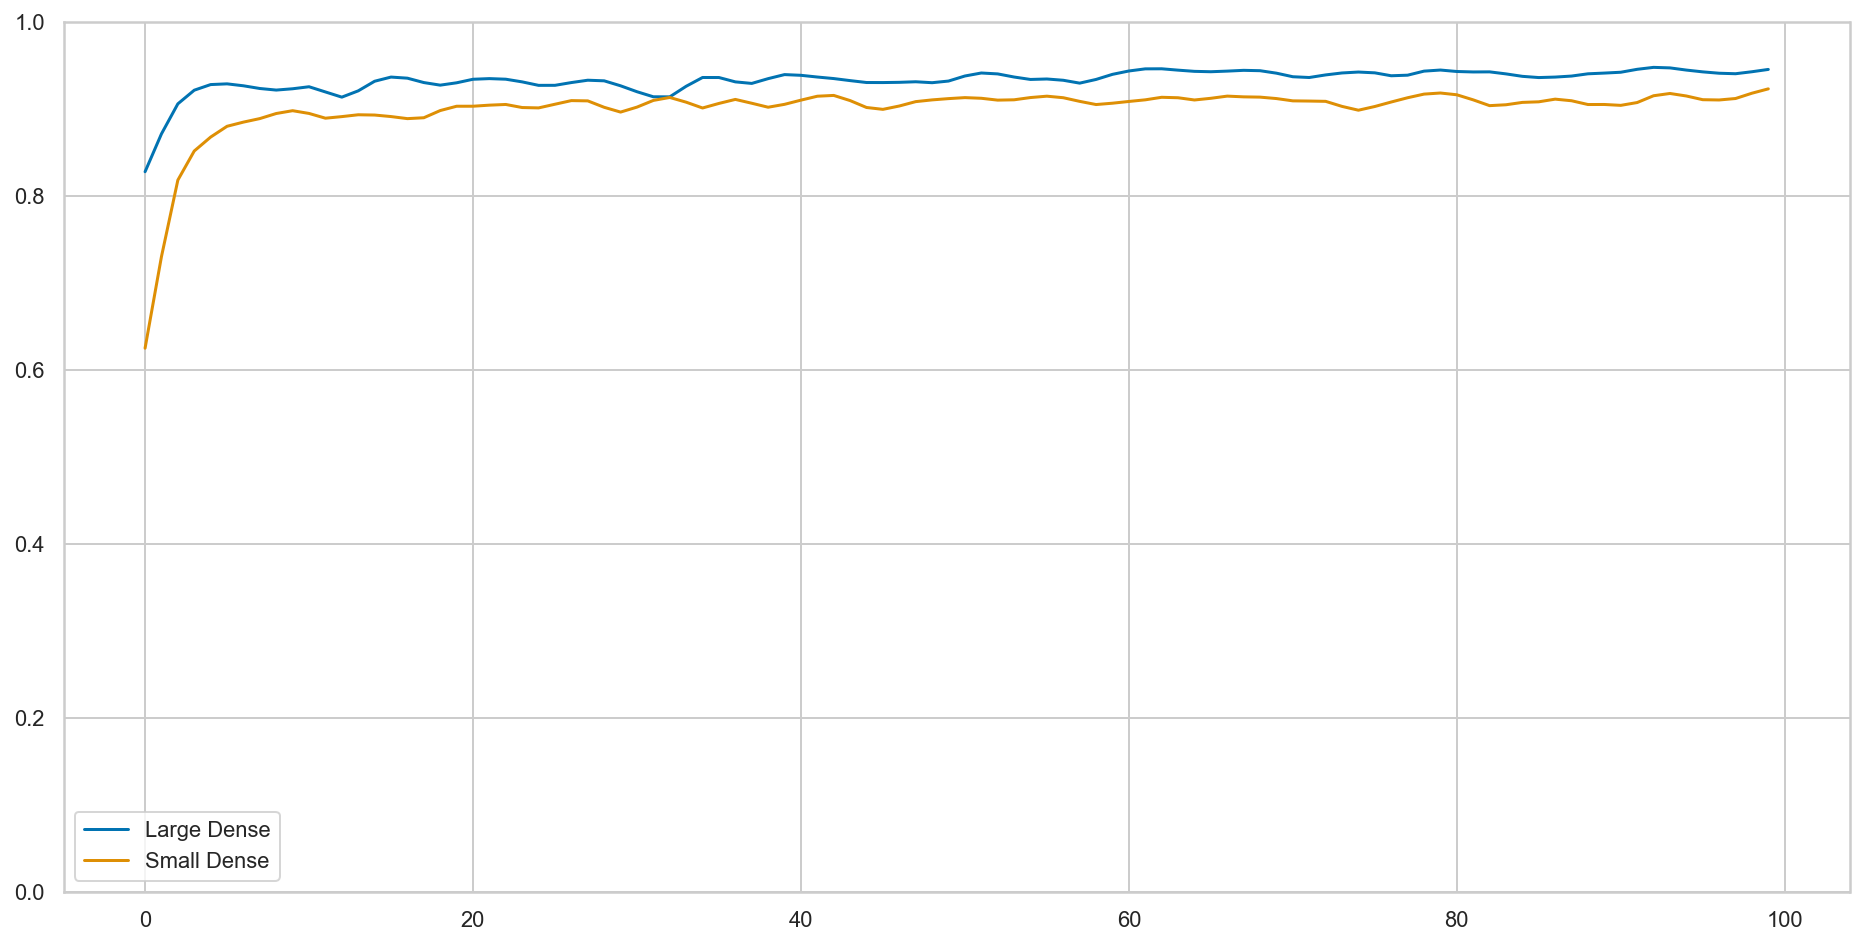

In [192]:
for network in ['GSCHeb', 'GSCHebSmall']:
    filter = (df['network'] == network) & (df['model'] == 'BaseModel')
    data = np.array(list(df[filter]['val_acc_all']))
    print(data.shape)
    data = data.mean(axis=0)
    print(data.shape)
    smoothed_data = gaussian_filter1d(data, sigma=1)
    # plt.plot(x, ysmoothed)
    plt.plot(smoothed_data, label=d[network])
    
plt.legend()
plt.ylim((0,1));

In [200]:
filter = df['on_perc'] == 0.04
agg('model', filter)

val_acc_max_epoch val_acc_max                      model
                       round_mean         min    max   mean    std count
model                                                                   
DSNNMixedHeb                   46       0.911  0.916  0.914  0.002     4
DSNNWeightedMag                84       0.922  0.927  0.924  0.002     4
SparseModel                    81       0.895  0.909  0.902  0.006     4